In [1]:
import colormaps as cmaps
import matplotlib.pyplot as plt
import opinionated
import polars as pl
import scipy
import seaborn as sns

# Set seaborn style
plt.style.use("opinionated_rc")
sns.set_palette(
    cmaps.bold[2:]._colors.tolist(),
)

/Users/evamaxfield/.local/share/mamba/envs/example-for-lab/lib/python3.13/site-packages/opinionated/__init__.py:24: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight Black
Now downloading: Fira Sans
Added new font as Fira Sans Light
Added new font as Fira Sans
Added new font as Fira Sans
Added new font as Fira Sans Black
Now downloading: Fira Sans Condensed
Added new font as Fira Sans Condensed Light
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed Black
Now downloading: IBM Plex Sans
Added new font as IBM Plex San

# Read in the Data to Python

In [2]:
# Read in the data
df = pl.read_csv("which-face-is-real-experiment.csv")

# "Clean" the Data

1. Make columns easier to select
2. Create a numeric encoding for the "social media hours" question
3. Clean up the text entry for score columns

In [3]:
# We only want the "INFO 300 Section", "On average...", "Pre-test score", and "Post-test score" columns
df = df.select(
    pl.col("INFO 300 Section").alias("section"),
    pl.col("On average, how many hours per day do you spend on social media?").alias("social_media_hours"),
    pl.col("Pre-test score\n").alias("pre_test_score"),
    pl.col("Post-test score\n").alias("post_test_score"),
)

# Next we want to convert "social_media_hours" to numeric
df = df.with_columns(
    pl.when(pl.col("social_media_hours") == "Less than 1 hour")
    .then(0)
    .when(pl.col("social_media_hours") == "1–2 hours")
    .then(1)
    .when(pl.col("social_media_hours") == "3–4 hours")
    .then(2)
    .when(pl.col("social_media_hours") == "5–6 hours")
    .then(3)
    .when(pl.col("social_media_hours") == "7–8 hours")
    .then(4)
    .when(pl.col("social_media_hours") == "More than 8 hours")
    .then(5)
    .otherwise(None)
    .alias("social_media_hours_numeric")
)

# Next we want to clean the pre and post test scores by
# first setting any rows that aren't either a single number or something /30 to null
# then second, setting any rows with a value over 30 to null
df = df.with_columns(
    pl.when(pl.col("pre_test_score").str.contains(r"^\d{1,2}$"))
    .then(pl.col("pre_test_score"))
    .when(pl.col("pre_test_score").str.contains(r"^\d{1,2}/30$"))
    .then(pl.col("pre_test_score").str.replace(r"/30", ""))
    .otherwise(None)
    .cast(pl.Int32).alias("pre_test_score_clean"),
    pl.when(pl.col("post_test_score").str.contains(r"^\d{1,2}$"))
    .then(pl.col("post_test_score"))
    .when(pl.col("post_test_score").str.contains(r"^\d{1,2}/30$"))
    .then(pl.col("post_test_score").str.replace(r"/30", ""))
    .otherwise(None)
    .cast(pl.Int32).alias("post_test_score_clean"),
).with_columns(
    pl.when(pl.col("pre_test_score_clean") > 30)
    .then(None)
    .otherwise(pl.col("pre_test_score_clean"))
    .alias("pre_test_score_clean"),
    pl.when(pl.col("post_test_score_clean") > 30)
    .then(None)
    .otherwise(pl.col("post_test_score_clean"))
    .alias("post_test_score_clean"),
).select(
    pl.col("section"),
    pl.col("social_media_hours"),
    pl.col("social_media_hours_numeric"),
    pl.col("pre_test_score_clean"),
    pl.col("post_test_score_clean"),
).with_columns(
    (pl.col("post_test_score_clean") - pl.col("pre_test_score_clean")).alias("score_change"),
)

df

section,social_media_hours,social_media_hours_numeric,pre_test_score_clean,post_test_score_clean,score_change
str,str,i32,i32,i32,i32
"""CB""","""3–4 hours""",2,19,22,3
"""CA""","""3–4 hours""",2,14,22,8
"""CA""","""3–4 hours""",2,10,28,18
"""CB""","""3–4 hours""",2,23,30,7
"""CA""","""5–6 hours""",3,10,25,15
…,…,…,…,…,…
"""CB""","""1–2 hours""",1,15,20,5
"""CA""","""5–6 hours""",3,12,18,6
"""CB""","""5–6 hours""",3,25,29,4


# Plots!!!

## Did Learning How to ID Work?

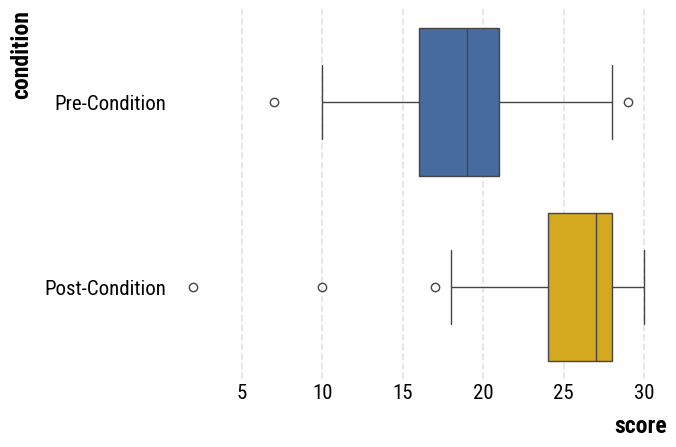

In [4]:
test_scores_for_plotting = df.select(
    pl.col("pre_test_score_clean").alias("Pre-Condition"),
    pl.col("post_test_score_clean").alias("Post-Condition"),
).drop_nans().drop_nulls().unpivot(
    on=["Pre-Condition", "Post-Condition"],
    variable_name="condition",
    value_name="score",
)

# Add basic plot
ax = sns.boxplot(
    data=test_scores_for_plotting.to_pandas(),
    x="score",
    y="condition",
    hue="condition",
)

### T-Test

In [5]:
scipy.stats.ttest_ind(
    df["pre_test_score_clean"].to_numpy(),
    df["post_test_score_clean"].to_numpy(),
    nan_policy="omit",
)

TtestResult(statistic=np.float64(-6.6810502164032926), pvalue=np.float64(1.1329746708112737e-09), df=np.float64(106.0))

## Does Lab Section Correlate with Social Media Hours?

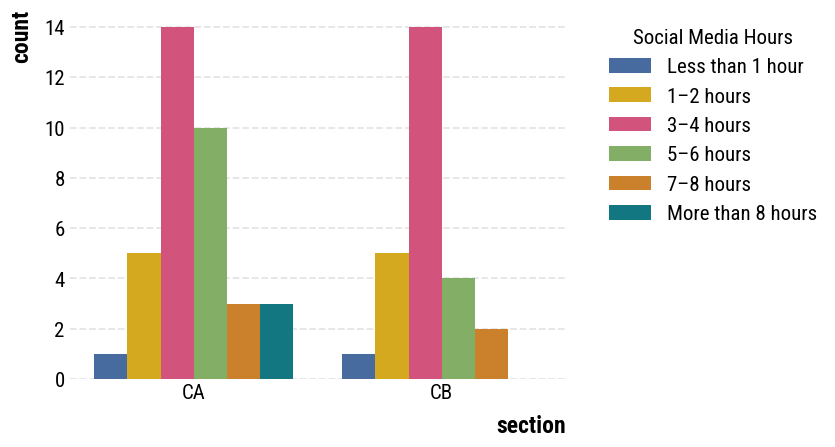

In [6]:
# Add basic plot
ax = sns.countplot(
    data=df.to_pandas(),
    x="section",
    order=["CA", "CB"],
    hue="social_media_hours",
    hue_order=[
        "Less than 1 hour",
        "1–2 hours",
        "3–4 hours",
        "5–6 hours",
        "7–8 hours",
        "More than 8 hours",
    ],
)

# Move legend outside of plot
ax.legend(
    title="Social Media Hours",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

### T-Test (Although, this could arguably be better tested as a Chi2)

In [7]:
scipy.stats.ttest_ind(
    df.filter(pl.col("section") == "CA").get_column("social_media_hours_numeric").to_numpy(),
    df.filter(pl.col("section") == "CB").get_column("social_media_hours_numeric").to_numpy(),
    nan_policy="omit",
)

TtestResult(statistic=np.float64(1.6607181318124444), pvalue=np.float64(0.10198764265140434), df=np.float64(60.0))

## Does Lab Section Correlate with Score Improvement?

<Axes: xlabel='score_change', ylabel='section'>

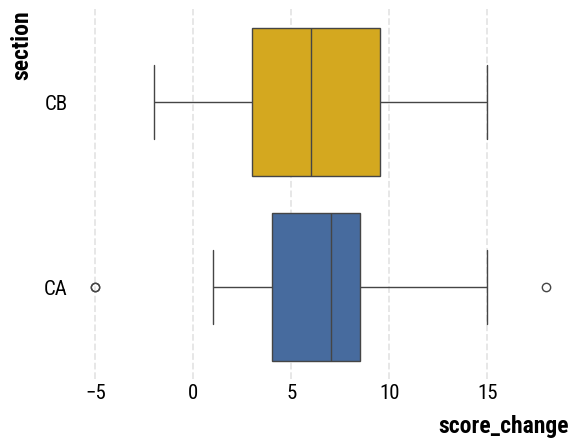

In [8]:
sns.boxplot(
    data=df.to_pandas(),
    x="score_change",
    y="section",
    hue="section",
    hue_order=["CA", "CB"],
)

### T-Test

In [9]:
scipy.stats.ttest_ind(
    df.filter(pl.col("section") == "CA")["score_change"].to_numpy(),
    df.filter(pl.col("section") == "CB")["score_change"].to_numpy(),
    nan_policy="omit",
)

TtestResult(statistic=np.float64(0.11557441765473624), pvalue=np.float64(0.9084350037135765), df=np.float64(52.0))

## Does Social Media Use Correlate with Score Improvement?

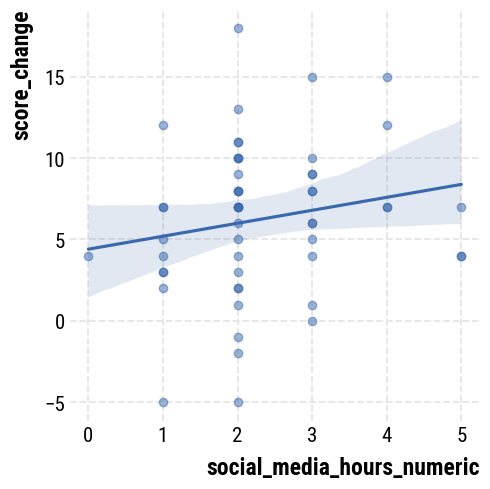

In [10]:
sns.lmplot(
    data=df.to_pandas(),
    x="social_media_hours_numeric",
    y="score_change",
    scatter_kws={"alpha":0.5}
)

### Spearman's Rank Correlation

In [11]:
scipy.stats.spearmanr(
    df["social_media_hours_numeric"].to_numpy(),
    df["score_change"].to_numpy(),
    nan_policy="omit",
)

SignificanceResult(statistic=np.float64(0.2056153458125367), pvalue=np.float64(0.13580602332184216))